In [1]:
import gensim # This is outside the anaconda distribution
import gensim.downloader as model_api
import lyricsgenius as genius # This is locally included

# little util library I include to help
from embeddingmerge import sentenceEmbedding, groupedEmbedding

import collections
import gc
import os
import numpy as np
import pandas as pd
import re
import seaborn as sns
import scipy as sc
import sklearn
from sklearn.decomposition import PCA
from sklearn.feature_extraction import text
from sklearn.manifold import TSNE
from sklearn import preprocessing
from types import FunctionType
from typing import Iterable

# connect the API token
api = genius.Genius('EbQ-sXA0l36oAFtKWUl6iWCN3wAeaFYzDRhla1LzJadbDhMZnmXy9i3NT6VTbHPQ')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data Collection / Preparation

We collect the data from Genius.com by using the [Genius API](https://docs.genius.com/). 

In [2]:
artist_list = [
    'Eminem', 'Taylor Swift', 'Sexion D\'Assaut', 'Wu-Tang Clan', 'Carlos Santana',
    'Hugo TSR', 'Toto', 'B.B. King', 'Blondie', 'ZZ Top', 'Bruce Springsteen', 'Mobb Deep',
    'Cat Stevens', 'Logic', 'Pink Floyd', 'Dream Theater', 'David Bowie', 'IAM', 'Ed Sheeran', 
    'NAS', 'A$AP Rocky', 'Drake', 'Bob Dylan', 'The Beatles', 'The Rolling Stones', 
    'Simon & Garfunkel',  'Stevie Wonder', 'Queen', 'Bob Marley & the Wailers', 
    'Neil Young', 'Leonard Cohen', 'Chance The Rapper', 'Michael Jackson', 
    'Burt Bacharach', 'U2', 'Kesha', 'DMX',
    'United States Court of Appeals, District of Columbia Circuit', 
    'United States Department of Justice', 
]

**Note:** This is commented out because it takes hours to collect the data. 

If you want to gather your own dataset, uncomment the following block and add artists to the above list.

You will also need to get your own API key from [here](https://genius.com/signup_or_login) to input to the *api* variable up top. Hint: you can put any valid URL to the site when making an account.

In [3]:
# for artist in artist_list:
#     artist_dir = "./data/{0}/".format(artist)
#     # need to create directory to write new files
#     if not os.path.exists(artist_dir):
#         os.makedirs(artist_dir)
#     try:
#         artist = api.search_artist(artist, max_songs=1000, verbose=False)
#         for _song in artist.songs:
#             try:
#                 lyrics = pd.DataFrame(_song.lyrics.splitlines())
#                 if len(lyrics) < 1:
#                     continue
#                 lyrics.to_csv(artist_dir + "{}.csv".format(
#                                 _song.title.replace("*", "_"
#                                           ).replace("/", " "
#                                           ).replace("?", ""
#                                           ).replace("\"", " "
#                                           ).replace("'", " "
#                                           ).replace("[", " "
#                                           ).replace("]", " "
#                                           ).replace("(", " "
#                                           ).replace(")", " "
#                                           ).replace("]", " ")
#                               ), index=False)
#             except Exception as e:
#                 print(e)
#                 print(artist)
#                 pass
#     except Exception as e:
#         print(e)
#         print(artist)
#         pass

**Gather the text data into a single DataFrame**

We do this by reading all individual songs into dataframes and concatening them together

In [4]:
df_list = []
data_path = "./data/"

for artist in os.listdir(data_path):
    for songname in os.listdir(data_path + artist + "/"):
        try:
            df_list.append(pd.read_csv(data_path + artist + "/" + songname))
            df_list[-1]["song"] = songname.replace(".csv", "")
            df_list[-1]["artist"] = artist
        except Exception as e:
            # Skip Broken Files
            pass

# Concatenate results into one dataframe
df = pd.concat(df_list)
df_list = None # clean up RAM

# remove useless column
df.drop("Unnamed: 0", 1, inplace=True)
# rename lyrics column
df.rename(columns={'0': 'lyrics'}, inplace=True)
# remove empty lyrics 
df.dropna(inplace=True)
# remove verse headers
# formatted like [Verse 1: A$AP Rocky]
verse_headers = df.lyrics.str.contains("[", regex=False)
df = df.loc[~verse_headers]
# realign index
df = df.reset_index(drop=True)
gc.collect() # clean up RAM
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


,lyrics,artist,song
0,"Ah, feelin' like a vigilante or a missionary",A$AP Rocky,1Train
1,"Tell my A$AP killers, get they pistols ready",A$AP Rocky,1Train
2,Send 'em to the cemetery with obituaries,A$AP Rocky,1Train
3,"Don't be scared, nigga, is you ready?",A$AP Rocky,1Train
4,I've been thinkin' 'bout all the O's in my ban...,A$AP Rocky,1Train


# Process text

We need to [tokenize](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html) the text to lists valid words

Our tokenization procedures are extremely naive -- This is meant to be educational

In [5]:
# cache original text to query on later
raw_text = df.copy()

# Lowercase errthang
df.lyrics = df.lyrics.str.lower()

# Replace all bad characters in one regex
replaceDict = {
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':"", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
}
rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
df.lyrics = df.lyrics.str.replace(pattern, lambda x: rep[re.escape(x.group(0))])

# Split by whitespace into tokens
df.lyrics = df.lyrics.str.split()
gc.collect()

# remove stopwords
stop = text.ENGLISH_STOP_WORDS
df['lyrics'] = df['lyrics'].apply(lambda x: [item for item in x if item not in stop])

In [6]:
df.head()

,lyrics,artist,song
0,"[ah, feelin, like, vigilante, missionary]",A$AP Rocky,1Train
1,"[tell, ap, killers, pistols, ready]",A$AP Rocky,1Train
2,"[send, em, cemetery, obituaries]",A$AP Rocky,1Train
3,"[dont, scared, nigga, ready]",A$AP Rocky,1Train
4,"[ive, thinkin, bout, os, bank, account]",A$AP Rocky,1Train


Notice the tokenization strategy here is very suboptimal: **Don't -> [dont]** but it should be **[do, n't]** or **[do, not]** to represent semantic meaning

# Compute TF-IDF weights

We want to compute weights for each word in each lyric to represent their importance in the sentence. The most popular method for this is [Term Frequency - Inverse Document Frequency](https://en.wikipedia.org/wiki/Tf–idf)

In [7]:
dct = gensim.corpora.Dictionary(df['lyrics'])
weightTupleList = None
corpus = [dct.doc2bow(line) for line in df['lyrics']]
tfidfTuples = gensim.models.TfidfModel(corpus)
weightTupleList = []
for line in df['lyrics']:
    wordFreq = collections.Counter(line)
    wordids = [wordId for wordId in dct.doc2idx(line) if wordId > -1]
    wordFreqs = [wordFreq[word] for word in line]
    bagOfWords = list(zip(wordids, wordFreqs))
    weightTupleList.append(tfidfTuples[bagOfWords])
    
weights = []
for wordlist in weightTupleList:
    w = np.array([weightTuple[1] for weightTuple in wordlist])
    weights.append(w / w.sum())

In [8]:
weights

[array([0.15992922, 0.18902744, 0.08526298, 0.27109125, 0.29468911]),
 array([0.12180862, 0.22869559, 0.22702751, 0.25691549, 0.16555278]),
 array([0.1994709 , 0.15045705, 0.29469263, 0.35537941]),
 array([0.15925059, 0.32204287, 0.22612259, 0.29258395]),
 array([0.10747924, 0.16332521, 0.13284846, 0.22311167, 0.17929941,
        0.19393601]),
 array([0.26935369, 0.25737901, 0.23996296, 0.23330434]),
 array([0.20628303, 0.27091544, 0.29345548, 0.22934604]),
 array([0.29588632, 0.21334542, 0.27595481, 0.21481344]),
 array([0.09984979, 0.09743845, 0.15372896, 0.10745517, 0.1235665 ,
        0.15372896, 0.1411972 , 0.12303497]),
 array([0.3165778 , 0.34323638, 0.34018582]),
 array([0.18687178, 0.22180403, 0.19672811, 0.14992946, 0.24466661]),
 array([0.12484662, 0.19355646, 0.18577359, 0.25384694, 0.2419764 ]),
 array([0.14392941, 0.21707962, 0.25831479, 0.0635742 , 0.0587872 ,
        0.25831479]),
 array([0.170569  , 0.13486567, 0.17541307, 0.12948268, 0.17009717,
        0.21957241]),


# Word Embeddings

We use a pretrained [Word Embedding](https://en.wikipedia.org/wiki/Word_embedding) from the wikipedia corpus using the [GLoVE technique](https://nlp.stanford.edu/projects/glove/).

In [10]:
# Load pretrained word embeddings
word_vectors = model_api.load("glove-wiki-gigaword-100")

Little Proof of concept on word embeddings:

Here we do $ (Paris - France) + Moscow = ?$

In [64]:
word_vectors.most_similar_cosmul(positive=['paris', 'moscow'], negative=['france'])

[('petersburg', 1.0073636770248413),
 ('kiev', 0.9882755875587463),
 ('vienna', 0.9633239507675171),
 ('kremlin', 0.9613880515098572),
 ('prague', 0.9605887532234192),
 ('tokyo', 0.9456755518913269),
 ('tbilisi', 0.9434913396835327),
 ('berlin', 0.9420398473739624),
 ('belgrade', 0.9384507536888123),
 ('helsinki', 0.9351786971092224)]

In [65]:
word_vectors.most_similar_cosmul(positive=['king', 'woman'], negative=['man'])

[('queen', 0.896455705165863),
 ('monarch', 0.8495979309082031),
 ('throne', 0.8447030782699585),
 ('princess', 0.8371669054031372),
 ('elizabeth', 0.8356794714927673),
 ('daughter', 0.8348595499992371),
 ('prince', 0.8230059742927551),
 ('mother', 0.8154449462890625),
 ('margaret', 0.8147734999656677),
 ('father', 0.8100854158401489)]

# Embed Sentences

First get the matrix of weighed sentence embeddings.

We embed sentences by simply taking the weighed average (or sum) of the words in the sentence 

Note the methods to do this are hidden away in another file to avoid clogging up the notebook

In [11]:
lyricEmbeddings = sentenceEmbedding(df['lyrics'], word_vectors, weights)

The embedding of a song is similarly the average or sum of the embeddings of the lyrics in the song

In [13]:
songEmbeddings = groupedEmbedding(df['lyrics'],
                                  groupByCol=df['song'], 
                                  model=word_vectors,
                                  weights=weights)
songEmbeddings = pd.DataFrame(songEmbeddings).T.reset_index(drop=False)
songEmbeddings.rename(columns={'index': 'song'}, inplace=True)
# add artist information to result
songEmbeddings = songEmbeddings.merge(df[['song', 'artist']].drop_duplicates(),
                                     left_on='song', right_on='song')

Similarly for an artist

In [ ]:
artistEmbeddings = groupedEmbedding(df['lyrics'],
                                  groupByCol=df['artist'], 
                                  model=word_vectors,
                                  weights=weights)
artistEmbeddings = pd.DataFrame(artistEmbeddings).T.reset_index(drop=False)
artistEmbeddings.rename(columns={'index': 'artist'}, inplace=True)

# Plotting

We can reduce the 100+ dimension word embeddings to 2 dimensions with manifold learning techniques (t-sne in this case). This lets us visualize the songs on a 2d chard.

For more info on t-sne, [see here](https://distill.pub/2016/misread-tsne/)

In [ ]:
vizEmbeddings = songEmbeddings[list(range(0, word_vectors.vector_size))]
# Reduce dimensionality to accelerate t-sne
vizEmbeddings = PCA(n_components=50).fit(vizEmbeddings.T).components_.T
# fit t-sne
tsne = TSNE(perplexity=500,
            learning_rate=250,
            metric='euclidean',
            method='barnes_hut',
            ).fit(vizEmbeddings)
tsnedf = pd.DataFrame(tsne.embedding_)
tsnedf['song'] = songEmbeddings['song']
tsnedf['artist'] = songEmbeddings['artist']

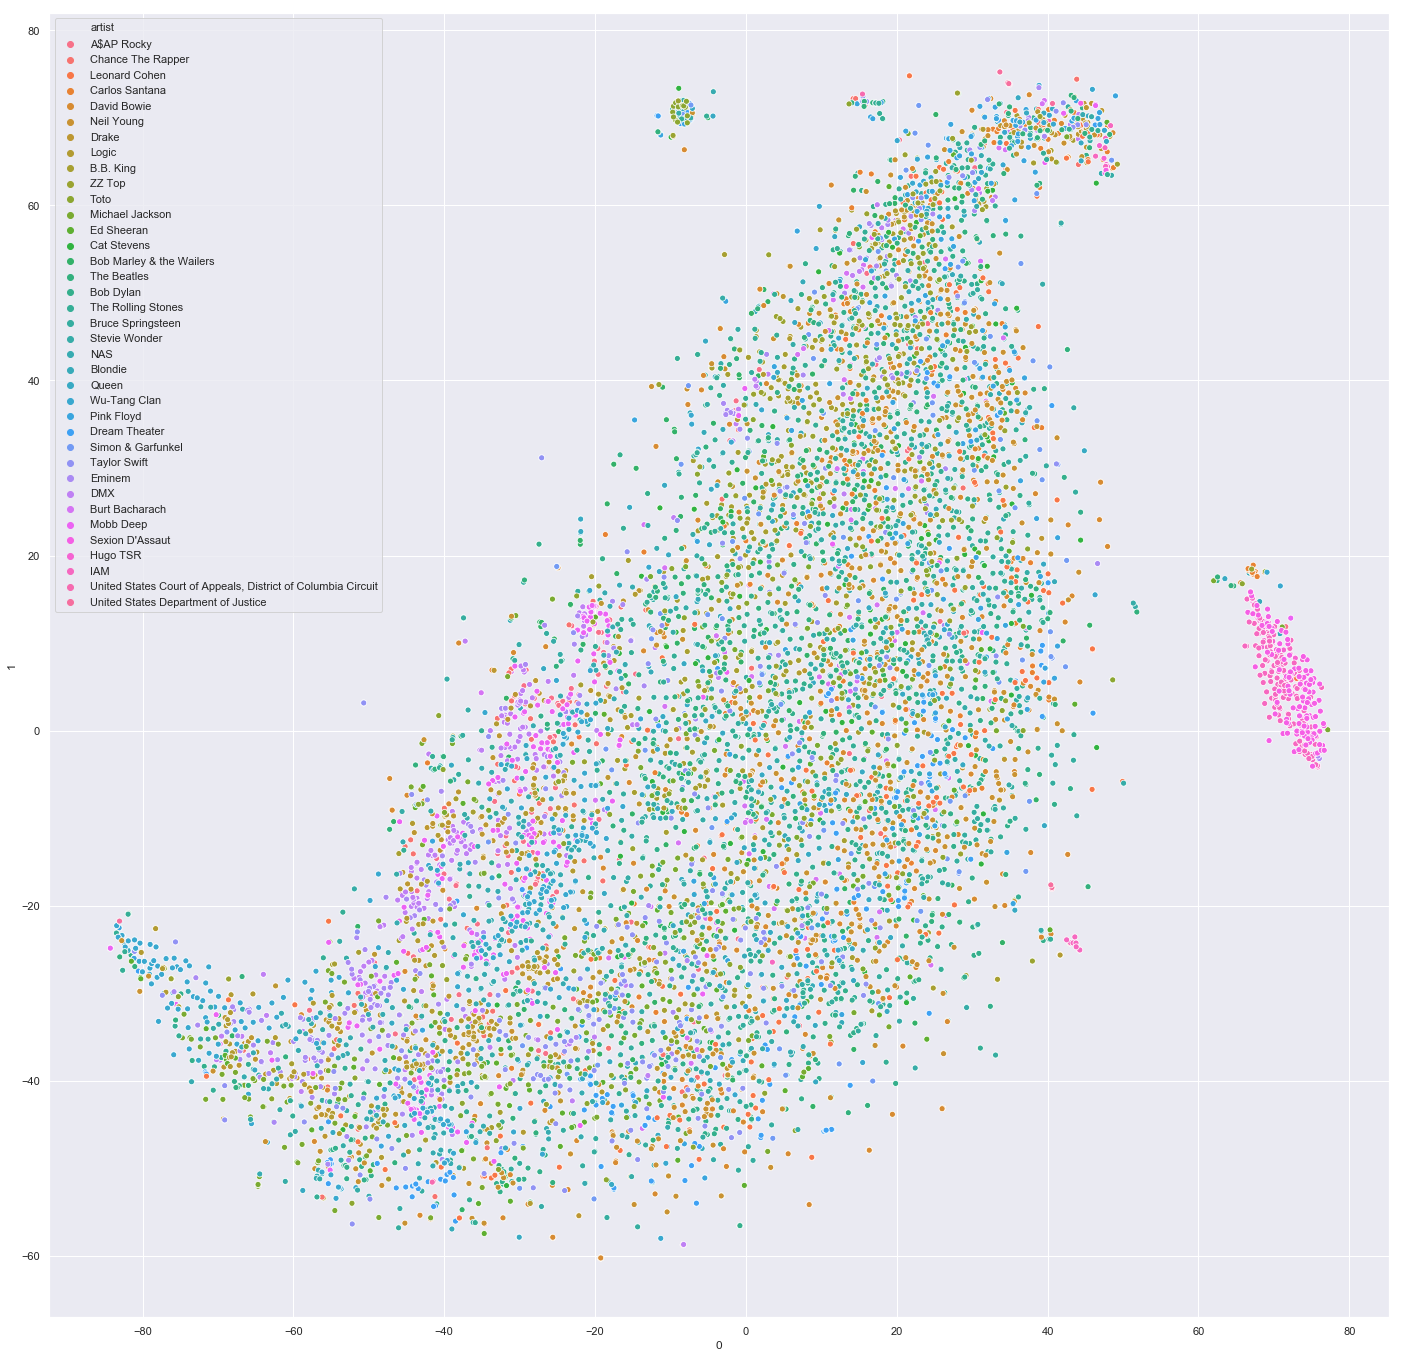

In [33]:
fig, ax = plt.subplots(figsize=(24, 24))
# Note sns.scatterplot is only available in seaborn v0.9 (not in default anaconda as of 07-2018)
sns.scatterplot(tsnedf[0], tsnedf[1], hue=tsnedf['artist'], ax=ax)

# Get closest lyric to a sentence

We can query our results for nearest neighbors using a [K-D tree](https://en.wikipedia.org/wiki/K-d_tree).

This lets us do fun things like get the closest lyric to an input sentence, or the closest lyric to an artist's embedding

In [18]:
nor = preprocessing.normalize(lyricEmbeddings)
lyricTree = sklearn.neighbors.KDTree(nor, metric="euclidean")
gc.collect()

139

In [29]:
def string2vec(s, model=word_vectors, 
               replacerRegex=pattern,
               stopwordlist=stop):
    """
    Transform string s into array of word vectors
    applies string -> vector procedures from section 2
    """
    s = s.lower()
    s = replacerRegex.sub(lambda x: rep[re.escape(x.group(0))], s)
    s = s.split()
    s = [w for w in s if w not in stopwordlist]
    return preprocessing.normalize(sentenceEmbedding([s], model))

In [53]:
to_evaluate = "i like rap"
query_length = 5

In [58]:
dist, ind = lyricTree.query(string2vec(to_evaluate), k=query_length)

print("Test Sentence: \n\t", to_evaluate, 
      "\n\n---------Matches-----------\n\n")
for i in range(len(ind[0])):
    print(raw_text.iloc[ind[0][i]], 
          "\ndistance: ", dist[0][i],
          "\n-----------------------\n")

Test Sentence: 
	 i like rap 

---------Matches-----------


lyrics    Rap like it was before
artist                       IAM
song                  Rigamortis
Name: 229089, dtype: object 
distance:  0.1949378198853202 
-----------------------

lyrics    And how I should come out and what to rap about
artist                                             Eminem
song                                             G.O.A.T.
Name: 197037, dtype: object 
distance:  0.3528697611094709 
-----------------------

lyrics    ‘Cause I don't like rap anyway
artist                            Eminem
song                         Get You Mad
Name: 197363, dtype: object 
distance:  0.3684441899909641 
-----------------------

lyrics    Only way you know I rap is if you see me rappin’
artist                                               Drake
song                                            You Got Me
Name: 164368, dtype: object 
distance:  0.3757462245922158 
-----------------------

lyrics    Nobody is going 

# Representative lyric for an artist

In [ ]:
query_artist = artistEmbeddings.iloc[0]

In [ ]:
dist, ind = lyricTree.query(query_artist, k=query_length)

print("Test Sentence: \n\t", to_evaluate, 
      "\n\n---------Matches-----------\n\n")
for i in range(len(ind[0])):
    print(raw_text.iloc[ind[0][i]], 
          "\ndistance: ", dist[0][i],
          "\n-----------------------\n")